# A ML-based networks evaluation and prediction system

Communication system reliability is a key point for **Beyond Visual Line of Sight (BVLOS)** Unmanned Aerial Vehicles (UAVs) applications, where the pilot has to remotely drive the drone relying on the real-time telemetry data and video feeds coming from the UAV. In order to achieve the maximum communication system reliability level for such applications, many wireless communication protocols must be adopted, together with a a powerful on-board central gateway able to handle different heterogeneous protocols and thus route data toward the most suitable one, ensuring redundancy and fail safe capabilities. Behind the physical implementation of the system, a strong network evaluation, prediction and selection mechanism must be implemented, in order to continuously determine the current link quality and **predict the radio link Quality of Service (QoS) based on the main flight parameters of the UAV**, such as speed, attitude and altitude, which mainly affects the radio signal propagation in the environment, as illustrated in Figure 1. 

![](https://drive.google.com/uc?id=1or5bMLdhf38_lYLGSWMXkBe7XRzruY-M)

### Figure 1: On-board multi-interface GW with QoS evaluation and prediction capabilities

# Evaluated networks and parameters

During the flights, plenty of data are collected every few seconds. The collection interval depends on the network interface capabilities, which can be very different given their heterogeneous nature. Actually the system is based on three different wireless communication protocols, they are:


*   **LTE (4G) cellular networks**;
*   **2.4 and 5 GHz Wi-Fi AC (IEEE 802.11)**;
*   **LoRaWAN**;

These networks have very different behaviors and application (Wi-Fi is used for short range application, while LoRaWAN for long range, LTE instead, for high throughput and wide range bidirectional communication) but they have similar Radio Quality indexes, which can be used for both evaluation and prediction purposes, specially if associated with the main UAV flight parameters.

### LTE parameters and collection rate
On our system, **LTE (4G) cellular network** interface has an average 1.2 seconds data collection interval, at least for the main Radio Quality indexes (so related to the PHY layer). In detail the most relevant parameters used for this project are the **Reference Signal Received Quality (RSRQ)** and the **Signal-to-Interference-plus-Noise Ratio (SINR)**. Unlike LoRaWAN, the **Receiver Signal Strength Index (RSSI)** has been discarded, since it often reach the upper and lower bound of the modem used for the data collection, therefore providing unuseful data.

Furthermore, in order to evaluate also the network performance at the IP/Application layer, additional evaluation parameters came form periodical *Speedtests*, which are dummy data data transfers, and *Latency tests*, providing an additional dataset for a more enhanced network evaluation. However, both on Wi-Fi and LTE, these kind of data have a greater collection time, which depends on the network performance and can vary from 15 up to 60 seconds, therefore **in this preliminary prediction model these kind of data have not been used yet**, given the much different collection frequency between the IP and PHY-layers data.

### Lorawan parameters and collection rate
Dealing with LoRaWAN networks requires a completely different network evaluation method, since, unlike cellular networks, the main Radio Quality indexes can only be evaluated by the Access Points which offer network coverage on a specific region. Therefore, only an offline evaluation can be done, thus making it necessary to **train a prediction model based on a priori measurments**, in order to provide a tool to the on-board GW of the drone which theoretically estimate the possible LoRaWAN network reliability based on the UAV in-flight parameters. To this end, the **Signal-to-Interference-plus-Noise Ratio (SINR)** and the **Receiver Signal Strenght Index (RSSI)** are collected by the receivers with a frequency of 7.5 seconds.

### Wi-Fi parameters and collection rate
As for LoRaWAN and LTE networks, in the preliminary Wi-Fi model only the **Signal-to-Interference-plus-Noise Ratio (SINR)** and the **Receiver Signal Strength Index (RSSI)** are actually evaluated, but given the high *low-level-control* allowed by the Wi-Fi interface adapter, there a lot of secondary useful parameters which can be used to tune and improve the model accuracy in a possible updated prediction system. All these parameters are collected every 10 seconds.

### UAV Flight Parameters
In order to create a prediction model for each kind of network, all the different wireless communications protocols quality indexes must be linked together with the main drone parameters observed during data collection. Unlike all the other network interfaces, **the data collection rate for such parameters is much higher**, reaching a 10 Hz sample rate. Therefore, in order to limit duplicate or partially empty row data, every time one of the aforementioned interfaces collect their evaluation data, the last drone flight parameters are attached to the same raw of data, thus equalizing the sample rate of the drone data with the one of the network interface analyzed.

The main parameters collected from the drone Flight Controller are the attitude (Roll, Pitch, Yaw), the direction, the ground related speed and the **Global Navigation Satellite System (GNSS) position**, which is composed by the altitude, the latitude and the longitude.

# Notebook libraries

For more UI friendly graphs (they can be enlarged or turn some features ON and OFF), Plotly and Datapane have been used instead of Matplotlib, which has been limited to some negligible plots. 

In [1]:
import tensorflow as tf
from tensorflow import keras

#!pip install q keras==2.5.0rc0
#!pip install tensorflow==2.5
#!pip3 install plotly==4.14.3
#!pip3 install -U datapane
#!pip3 install matplotlib
#!pip3 install -U scikit-learn scipy matplotlib
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 --allow-root

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from pandas import DataFrame
import plotly.express as px
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas import concat
import pandas as pd
import operator
import numpy as np
import datapane as dp
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#import keras
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime, date, time, timedelta
from itertools import islice

pd.options.mode.chained_assignment = None  # default='warn'



/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LTE Data Import

The first data analyzed are related to the LTE (4G) cellular network, since it is the most relevant interface. Therefore, the JSON file with all the Radio Quality index has been loaded and converted into a DF. The same operation has been done with the Latency data (aka Ping). The two DFs will then be "virtually combined together for plotting purposes.

In [3]:
#Import LTE network data from JSON file
data = []
with open('/content/drive/MyDrive/Colab Notebooks/LTE.json') as f:
    for line in f:
        data.append(json.loads(line))

#Convert JSON data from Python dict to DF
LTE_DATA = pd.json_normalize(data)
LTE_DATA.head()

interface                   timestamp  ... gps_param.satellites gps_param.fix_type
0      eth1  2021-05-22 13:50:12.752036  ...                   15                  4
1      eth1  2021-05-22 13:50:12.752036  ...                   15                  4
2      eth1  2021-05-22 13:50:13.786250  ...                   15                  4
3      eth1  2021-05-22 13:50:13.786250  ...                   15                  4
4      eth1  2021-05-22 13:50:14.846186  ...                   15                  4

[5 rows x 27 columns]

In [4]:
#Import LTE network Ping data from JSON file
data = []
with open('/content/drive/MyDrive/Colab Notebooks/Ping.json') as f:
    for line in f:
        data.append(json.loads(line))

#Convert JSON data from Python dict to DF
LTE_PING = pd.json_normalize(data)
LTE_PING.head()

interface                   timestamp  ...  gps_param.satellites  gps_param.fix_type
0      eth1  2021-05-22 13:50:22.168969  ...                    15                   4
1      eth1  2021-05-22 13:50:22.168969  ...                    15                   4
2      eth1  2021-05-22 13:50:37.145031  ...                    15                   4
3      eth1  2021-05-22 13:50:37.145031  ...                    15                   4
4      eth1  2021-05-22 13:50:52.237218  ...                    15                   4

[5 rows x 23 columns]

# Preliminary Data Clean

A preliminary data clean is performed by dropping duplicate rows (a lot!) based on their timestamp. Also, since the modem also support 2G and 3G networks, the DF is skimmed to 4G network only.

In [5]:
#Drop duplicate data where rows have same timestamp
LTE_DATA = LTE_DATA.drop_duplicates(subset=['timestamp'])
LTE_PING = LTE_PING.drop_duplicates(subset=['timestamp'])

#Set LTE condition
LTE_net = LTE_DATA['net_param.net_type']=='LTE'
LTE_DATA = LTE_DATA[LTE_net]

Since the modem has some upper and lower bounds in the measurements, in order to avoid non-numerical values due to exceeding of the limits, all that exception are replaced with numerical values. Then the two DF numerical values are converted into Float.

In [6]:
#Replace all that values at the boudaries with integer values, so that they can be converted into float
LTE_DATA = LTE_DATA.replace(['>=-51','<=-113','<-20','<-19.5','<-140'],['-50','-120','-21','-20','-144'])

#Converto DF into float (only numbers)
LTE_DATA = LTE_DATA.apply(pd.to_numeric, errors='ignore')
LTE_PING = LTE_PING.apply(pd.to_numeric, errors='ignore')

In order to remove unreliable data where the GNSS accuracy is too low, the number of satellites conditions is set on both data. Finally, the timestamp field is converted into the datetime format and then all the rows are ordered by time, which will later allow an easier time clustering of the flights.

In [7]:
#Set GPS_Fix condition
LTE_Null = LTE_DATA['gps_param.satellites']>=6
LTE_DATA = LTE_DATA[LTE_Null]
PING_Null = LTE_PING['gps_param.satellites']>=6
LTE_PING = LTE_PING[PING_Null]

#Convert timestamp into datetime
LTE_DATA["timestamp"] = pd.to_datetime(LTE_DATA["timestamp"])
LTE_PING["timestamp"] = pd.to_datetime(LTE_PING["timestamp"])

#Sort by time (needed for time clustering)
LTE_DATA = LTE_DATA.sort_values(by="timestamp")
LTE_PING = LTE_PING.sort_values(by="timestamp")

#Print Dtypes for debug
print(LTE_DATA.dtypes)
print(LTE_PING.dtypes)

interface                           object
timestamp                   datetime64[ns]
net_param.net_type                  object
net_param.rsrq                     float64
net_param.rsrp                       int64
net_param.rssi                       int64
net_param.sinr                       int64
net_param.band                       int64
net_param.pci                        int64
uav_param.mode                      object
uav_param.status                    object
uav_param.battery                  float64
uav_param.attitude.pitch           float64
uav_param.attitude.yaw             float64
uav_param.attitude.roll            float64
gps_param.latitude                 float64
gps_param.longitude                float64
gps_param.altitude                 float64
gps_param.groundspeed              float64
gps_param.velocity.vx              float64
gps_param.velocity.vy              float64
gps_param.velocity.vz              float64
gps_param.head                       int64
gps_param.h

# Time clustering to separate different flight mission

Since every flight mission has a duration between 12 and 18 minutes, in order to plot all the data collected within the same mission, the DFs must be "clustered" by time batch. In order to do this, the DF rows with a contiguous timestamp with a maximum of 2 minutes of difference are grouped together in the same list of rows. Therefore, after the time clustering, we will obtain a *list of DFs*, each one representing a flight. The operation is done on both LTE and Ping DFs, then the number of detected flights in both DF is printed.

In [8]:
#Convert timestamp of dataframe to python datetime
LTE_DATA.timestamp = LTE_DATA.timestamp.dt.to_pydatetime()
LTE_PING.timestamp = LTE_PING.timestamp.dt.to_pydatetime()

#CLUSTER LTE DF
#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=2)
final = list()
tmp = list()

#First row
tmp.append(LTE_DATA.iloc[0,:])

#First datetime
previous = LTE_DATA.iloc[0,1]

#Scan LTE dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
lte_flights = []
for i in range(len(final)):
    if len(final[i])>100:
        lte_flights.append(final[i])

#Print N° of flights
print("Found ", len(lte_flights), " flights with LTE network data")

#Print flight lenght
for i in range(len(lte_flights)):
    print("Flight N°", i+1, "has ", len(lte_flights[i]), " rows of data")

print('')

#CLUSTER LTE_PING DF
#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=3)
final = []
tmp = []

#First row
tmp.append(LTE_PING.iloc[0,:])

#First datetime
previous = LTE_PING.iloc[0,1]

#Scan LTE dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_PING.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
lte_ping_flights = []
for i in range(len(final)):
    if len(final[i])>10:
        lte_ping_flights.append(final[i])

#Print N° of flights
print("Found ", len(lte_ping_flights), " flights with LTE Ping network data")

#Print flight lenght
for i in range(len(lte_ping_flights)):
    print("Flight N°", i+1, "has ", len(lte_ping_flights[i]), " rows of data")


Found  11  flights with LTE network data
Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  489  rows of data
Flight N° 8 has  392  rows of data
Flight N° 9 has  376  rows of data
Flight N° 10 has  612  rows of data
Flight N° 11 has  553  rows of data

Found  11  flights with LTE Ping network data
Flight N° 1 has  35  rows of data
Flight N° 2 has  61  rows of data
Flight N° 3 has  93  rows of data
Flight N° 4 has  68  rows of data
Flight N° 5 has  64  rows of data
Flight N° 6 has  72  rows of data
Flight N° 7 has  48  rows of data
Flight N° 8 has  61  rows of data
Flight N° 9 has  63  rows of data
Flight N° 10 has  63  rows of data
Flight N° 11 has  57  rows of data


# Plot and Regression Functions

In this section of code, there are some plots and regression functions. Check comments inside the functions to understand what they do.

In [9]:
def format_coefs(coefs):
    #Function used to write the legend items as equations
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

def Scatter_plot_speed(DF):
    #Define figure
    fig_speed_scat = go.Figure()
 
    #Clean DF in order to keep only measurement at the "same" altitude, thus removing dependency on altitude
    MAX_Alt = DF['gps_param.altitude'].max()
    CUT_Alt = MAX_Alt*0.85 #Keep only the real flight data
    DF_Pos = DF['gps_param.altitude']>CUT_Alt
    DF = DF[DF_Pos]
    fig_speed_scat.add_trace(go.Scatter(x=DF['gps_param.groundspeed'], y=DF['net_param.sinr'], mode='markers', name='SNR'))
    fig_speed_scat.add_trace(go.Scatter(x=DF['gps_param.groundspeed'], y=DF['net_param.rsrq'], mode='markers', name='RSRQ'))
    
    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['gps_param.groundspeed'].values.reshape(-1,1)
    model.fit(X, DF['net_param.sinr'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='RSRQ Lin Reg'))
   
    #Linear Reg for RSRQ
    model = LinearRegression()
    model.fit(X, DF['net_param.rsrq'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='RSRQ Lin Reg'))
    
    #Set plots names
    fig_speed_scat.update_layout(title_text="SNR & RSRQ vs UAV Speed")
    
    #Set Axis name
    fig_speed_scat.update_xaxes(title_text="UAV Speed (m/s)")
    fig_speed_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_speed_scat.show()
        
def Scatter_plot_alt(DF):
    #Define figure
    fig_scat = go.Figure()

    #Plot signal quality index by altitude       
    fig_scat.add_trace(go.Scatter(x=DF['gps_param.altitude'], y=DF['net_param.sinr'], mode='markers', name='SNR'))
    fig_scat.add_trace(go.Scatter(x=DF['gps_param.altitude'], y=DF['net_param.rsrq'], mode='markers', name='RSRQ'))

    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['gps_param.altitude'].values.reshape(-1,1)
    x_range = np.linspace(X.min(), X.max(), 600).reshape(-1, 1)
    for degree in [1, 2, 3]:
        # Get degree and fit
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, DF['net_param.sinr'])
        y_poly = model.predict(x_range_poly)
        
        # Write as equation
        equation = format_coefs(model.coef_.round(2))
        # Add to plot
        fig_scat.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
       
    #Linear Reg for RSRQ
    model = LinearRegression()
    X = DF['gps_param.altitude'].values.reshape(-1,1)
    x_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    for degree in [1, 2, 3]:
        # Get degree and fit
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, DF['net_param.rsrq'])
        y_poly = model.predict(x_range_poly)
        
        # Write as equation
        equation = format_coefs(model.coef_.round(2))
        # Add to plot
        fig_scat.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
    
    #Set plots names
    fig_scat.update_layout(title_text="SNR & RSRQ vs UAV Altitude")

    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()
    

def Scatter_map(DF):
    #Create scatter maps
    scat_map = px.scatter_mapbox(DF, lat='gps_param.latitude', lon='gps_param.longitude', color='net_param.sinr', size='gps_param.longitude', zoom=16,
                        mapbox_style="open-street-map")
    
    # Set plot name
    scat_map.update_layout(title_text="LTE Coverage Map")
    
    # Show
    scat_map.show()
    
def Flight_plot(DF):   
    #Flight match between the two DF
    first_LTE_time = lte_complete_flights[f].iloc[0,1]
    delta = timedelta(minutes=1)
    for i in range(len(lte_ping_complete_flights)):
        first_LTE_ping_time = lte_ping_complete_flights[i].iloc[0,1]    
        if abs(first_LTE_ping_time - first_LTE_time) < delta:
            print("Matched LTE Flight N°", f+1,"with LTE Ping Flight N°",i+1)
            DF_ping = DataFrame (lte_ping_complete_flights[i])
            
    # Create figure with secondary y-axis
    fig_lines = make_subplots(specs=[[{"secondary_y": True}]])

    #Set first axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.sinr'], name="SINR (dBm)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['gps_param.altitude'], name="Altitude (m)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['gps_param.groundspeed'], name="Groundspeed (m/s)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.rsrq'], name="RSRQ (dBm)"), secondary_y=False)
    try:
        #Cutoff big ping value to 100, which is already an ugly value
        DF_ping['net_param.avg_latency'][DF_ping['net_param.avg_latency']>100] = 100
        fig_lines.add_trace(go.Scatter(x=DF_ping['timestamp'], y=DF_ping['net_param.avg_latency'], mode='markers', name="PING (ms)"), secondary_y=False)
    except:
        print("No Ping data for this flight")
        
    #Set second axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.rssi'], name="RSSI (dBm)"), secondary_y=True)
    
    # Set x-axis title
    fig_lines.update_xaxes(title_text="Time")
    
    # Set y-axes titles
    fig_lines.update_yaxes(title_text="Altitude, Sinr, Groundspeed, RSRQ, Ping", secondary_y=False)
    fig_lines.update_yaxes(title_text="RSSI", secondary_y=True)
    
    # Set title
    fig_lines.update_layout(title_text="LTE Network and UAV data")
    
    # Show
    fig_lines.show()   
    
    
def Band_plot(DF):   
    # Create figure with secondary y-axis
    fig_lines = make_subplots(specs=[[{"secondary_y": True}]])

    #Set first axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.band'], mode='markers', name="Band"), secondary_y=False)
    
    #Set second axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.pci'], mode='markers', name="Cell ID"), secondary_y=True)
        
    # Set x-axis title
    fig_lines.update_xaxes(title_text="Time")
    
    # Set y-axes titles
    fig_lines.update_yaxes(title_text="Band", secondary_y=False)
    fig_lines.update_yaxes(title_text="Cell ID", secondary_y=True)
    
    # Set title
    fig_lines.update_layout(title_text="LTE Network Cells and Bands")
    
    # Show
    fig_lines.show()

### Plot the LTE bands detected during all the flights

In [10]:
Band_plot(LTE_DATA)

### Plot a nice heatmap with all the LTE measurement

In [11]:
LTE_RSSI_HM = px.density_mapbox(LTE_DATA, lat='gps_param.latitude', lon='gps_param.longitude', z='net_param.sinr', zoom=12,
                        mapbox_style="open-street-map")
LTE_RSSI_HM.show()

# Remove all the incomplete flights

During the flights the GW overheated and stopped working properly, therefore some flights are incomplete, which means that the initial and final value of the altitude of the UAV is not the same ("it did not land"). Thus, they must be discarded. Finally, all the clean and complete data are plotted recalling the previously defined functions, which also perform some simple preliminary Regressions.

In [12]:
#Remove incomplete flights where there are missing data by check initial and final altitude with a 5 meter error margin due to air pressure change
lte_complete_flights = []
for i in range(len(lte_flights)):
    data = DataFrame (lte_flights[i])
    rth = abs(data.iloc[0,17] - data.iloc[-1,17])
    if rth<10:
        lte_complete_flights.append(data)
        
lte_ping_complete_flights = []
for i in range(len(lte_ping_flights)):
    data = DataFrame (lte_ping_flights[i])
    rth = abs(data.iloc[0,13] - data.iloc[-1,13])
    if rth<10:
        lte_ping_complete_flights.append(data) 
        
#Print complete flight data plots
for f in range(len(lte_complete_flights)):
    print("Create all graphs related to LTE data of flight N°", f+1)
    
    #get DF
    DF = DataFrame (lte_complete_flights[f])

    #Call Plot functions
    Flight_plot(DF)
    Scatter_map(DF)
    Scatter_plot_alt(DF)
    Scatter_plot_speed(DF)   
    


Create all graphs related to LTE data of flight N° 1
Matched LTE Flight N° 1 with LTE Ping Flight N° 1


Create all graphs related to LTE data of flight N° 2
Matched LTE Flight N° 2 with LTE Ping Flight N° 2


Create all graphs related to LTE data of flight N° 3
Matched LTE Flight N° 3 with LTE Ping Flight N° 3


Create all graphs related to LTE data of flight N° 4
Matched LTE Flight N° 4 with LTE Ping Flight N° 4


Create all graphs related to LTE data of flight N° 5
Matched LTE Flight N° 5 with LTE Ping Flight N° 5


Create all graphs related to LTE data of flight N° 6
Matched LTE Flight N° 6 with LTE Ping Flight N° 6


Create all graphs related to LTE data of flight N° 7
Matched LTE Flight N° 7 with LTE Ping Flight N° 7


Create all graphs related to LTE data of flight N° 8
Matched LTE Flight N° 8 with LTE Ping Flight N° 8


# Preliminary Regression discussion

### RSRQ and SNR vs Altitude

Looking at the graphs and Regression with one, two or three parameters, it is possible to observe that generally such Radio Signal quality indexes decrease by increasing the UAV flight altitude, with the curve flattening from 90-100 meters and higher altitude. This is due to two main reasons:



1.   LTE Cellular Networks are design and tuned for terrestrial usage;
2.   Given the Direct Line of Sight between the UAV and multiple LTE antennas, there is much more inter-cells interference due to nearby cells. That's also why the RSSI (e,g, the received signal power) is always at the maximum level allowed by the modem. Unfortunately, given the very low SNR and RSRQ, most of the received signal power is pure interference caused by the frequency re-use of the nearby LTE cells.



### RSRQ and SNR vs Speed

The UAV speed does not seem to affect the signal quality, given the flat behaviour of the curve, that's also why a linear Regression is fine.
Literature confirms that such speeds does not affect LTE radio signals.

# Advanced polynomial regression

In order to better understand and evaluate a Polynomial Regression-based LTE SNR and RSRQ forecast model, an enhanced Regression is performed on all the data collected during the flights. Also, a train and test sets are defined, in order to measure the RMSE of the model at different degree of freedom. All the results are then plotted and shown, allowing a fast and simple evaluation.

In [13]:
#Performing some real Poly Reg to find a suitable model for SNR prediction at different height, since speed does not affect SNR index
def polynomial_regression_model(degree):
    print("Creates a polynomial regression model for "+str(degree)+" degree")
    poly = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_poly = poly.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    model = LinearRegression()
    model.fit(X_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = model.predict(X_poly)

    # predicting on test data-set
    y_test_predict = model.predict(poly.transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    
    #Define figure
    fig_scat = go.Figure()
    
    #Plot Train & Test Data
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=Y_train[:,0], mode='markers', name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=Y_test[:,0], mode='markers', name='Test'))

    #Add Linear Regression
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=y_train_predicted[:,0], name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=y_test_predict[:,0], name='Test'))
    
    #Set plots names
    fig_scat.update_layout(title_text="SNR vs UAV Alt")
    
    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()

    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")


# Create Train and Test DFs and call the function

The LTE DF is converted into a Numpy array and only the usefull colums are collected (SNR and Altitude). Then the Train and Test sets are created and properly reshaped. Finally, the Poly Function previously defined is called for 5 degree of freedom.

In [14]:
#From DF to NP array
array = LTE_DATA.values

#Get only usefull colums
X = array[:,17]
Y = array[:,6]

#Split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

#Reshape to 2D
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

#Order by X
Y_train = Y_train[X_train[:,0].argsort()]
X_train = X_train[X_train[:,0].argsort()]
Y_test = Y_test[X_test[:,0].argsort()]
X_test = X_test[X_test[:,0].argsort()]
    
# Evaluate Logisti Regression Perf
for degree in [1, 2, 3, 4, 5]:
    polynomial_regression_model(degree)

Creates a polynomial regression model for 1 degree


RMSE of training set is 3.650015580004965
R2 score of training set is 0.3357801349599354
-------------------------------------------
RMSE of test set is 3.6182707476638503
R2 score of test set is 0.31884306271436924


Creates a polynomial regression model for 2 degree


RMSE of training set is 3.5377742414923787
R2 score of training set is 0.3760027803446807
-------------------------------------------
RMSE of test set is 3.5106359442087505
R2 score of test set is 0.3587658370972723


Creates a polynomial regression model for 3 degree


RMSE of training set is 3.5259836694357083
R2 score of training set is 0.3801551222571711
-------------------------------------------
RMSE of test set is 3.5016849345356866
R2 score of test set is 0.36203155652026764


Creates a polynomial regression model for 4 degree


RMSE of training set is 3.499014347281017
R2 score of training set is 0.38960092040331606
-------------------------------------------
RMSE of test set is 3.468032958547753
R2 score of test set is 0.3742346751213853


Creates a polynomial regression model for 5 degree


RMSE of training set is 3.4827251806552093
R2 score of training set is 0.3952709448539109
-------------------------------------------
RMSE of test set is 3.451111590705481
R2 score of test set is 0.3803262969175314




# Repeat the Poly Regression for RSRQ

In [15]:
#Performing some real Poly Reg to find a suitable model for RSRQ prediction at different height, since speed does not affect SNR index
def polynomial_regression_model(degree):
    print("Creates a polynomial regression model for "+str(degree)+" degree")
    poly = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_poly = poly.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    model = LinearRegression()
    model.fit(X_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = model.predict(X_poly)

    # predicting on test data-set
    y_test_predict = model.predict(poly.transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    
    #Define figure
    fig_scat = go.Figure()
    
    #Plot Train & Test Data
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=Y_train[:,0], mode='markers', name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=Y_test[:,0], mode='markers', name='Test'))

    #Add Linear Regression
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=y_train_predicted[:,0], name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=y_test_predict[:,0], name='Test'))
    
    #Set plots names
    fig_scat.update_layout(title_text="RSRQ vs UAV Alt")
    
    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()

    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")

#From DF to NP array
array = LTE_DATA.values

#Get only usefull colums
X = array[:,17]
Y = array[:,3]

#Split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

#Reshape to 2D
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

#Order by X
Y_train = Y_train[X_train[:,0].argsort()]
X_train = X_train[X_train[:,0].argsort()]
Y_test = Y_test[X_test[:,0].argsort()]
X_test = X_test[X_test[:,0].argsort()]
    
# Evaluate Logisti Regression Perf
for degree in [1, 2, 3, 4, 5]:
    polynomial_regression_model(degree)

Creates a polynomial regression model for 1 degree


RMSE of training set is 2.5916240836368987
R2 score of training set is 0.18640259931927716
-------------------------------------------
RMSE of test set is 2.5768956084012173
R2 score of test set is 0.20445509912081017


Creates a polynomial regression model for 2 degree


RMSE of training set is 2.5722680493487977
R2 score of training set is 0.19851022770142623
-------------------------------------------
RMSE of test set is 2.5557927479651714
R2 score of test set is 0.21743159007223622


Creates a polynomial regression model for 3 degree


RMSE of training set is 2.559582028891936
R2 score of training set is 0.20639637538707234
-------------------------------------------
RMSE of test set is 2.542640158725864
R2 score of test set is 0.2254653529921593


Creates a polynomial regression model for 4 degree


RMSE of training set is 2.5554493635199735
R2 score of training set is 0.2089569891935904
-------------------------------------------
RMSE of test set is 2.535655883225225
R2 score of test set is 0.2297145847880635


Creates a polynomial regression model for 5 degree


RMSE of training set is 2.553713451524446
R2 score of training set is 0.21003133225932835
-------------------------------------------
RMSE of test set is 2.539255180110613
R2 score of test set is 0.22752623293036978




# Polynomial Regression Discussion

### SNR

All the models with different degrees of freedom have a very low R2 score. The best one is the Polynomial Regression with 3 DoF, which has a *awful* R2 score of about 0.36 and an RMSE of 3.5. The model with 1 and 2 DoF underfit the dataset, while with 4 and 5 DoF heavily overfit it.

### RSRQ

All the models have a very low R2 score, even lower then the SNR models. They all have similar R2 values, but the best one is the Polynomial Regression with 4 DoF, which has a *very awful* R2 score of about 0.22 and an RMSE of 2.5. However, it seems *partially* overfitting the data, while the 5 DoF model clearly overfit the data set.

### Conclusion

Polynomial Regression is not suitable for such *poor relation-less dataset*, however SNR 3 DoF model is already *on-track* with the real behaviour of the network parameter. Even trying with additional features, like the attitude of the UAV, does not change the reliability of the models.

# GEO Clustering attempt

An attempt of GEO clustering based on the geographical coordinates of the surveys using Kmeans. First a preliminary Elbow plot is done in order to evaluate the right number of clusters.

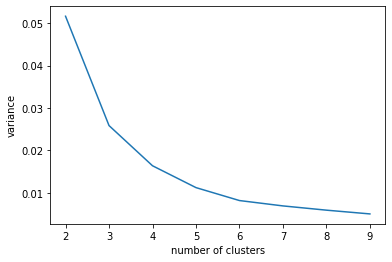

In [16]:
#GEO Clustering attempt
df = DataFrame(LTE_DATA,columns=['gps_param.latitude','gps_param.longitude'])

#Create Elbow plot to find the best number of clusters
nc = []
N = np.arange(2, 10)
for n in N:
    c = KMeans(n_clusters = n).fit(df)
    nc.append(c.inertia_)

plt.plot(N, nc);
plt.xlabel('number of clusters');
plt.ylabel('variance');

Then the cluster is set to 5 and the clustering is performed. A final plot with the cluster centers and all the points is also available

[[45.00564012 10.4617385 ]
 [44.99040582 10.45255975]
 [45.00485526 10.46898937]
 [45.00754124 10.46380307]
 [45.00627937 10.45731644]]


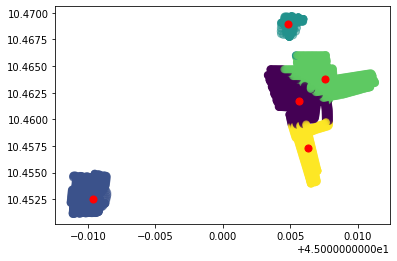

In [17]:
#Set to 5 clusters
kmeans = KMeans(n_clusters=5).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['gps_param.latitude'], df['gps_param.longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# LSTM Recurrent Neural Network (RNN)

Among a plethora of ML algorithm, I found that Long Short term Memory (LSTM) Recurrent Neural Networks are the most suitable for this kind of data forecasting, since I studied many example based on this algo used for continuous value variable prediction (e.g., temperature, pollution, etc), like in this project.

Also I found that LSTM works very well for forecasting based on time series inputs, like in this case, where I have multiple time series related to different networks.


## Convert time series to supervised learning problem

The first step is to transform the multivariable time series into a supervised learning problem. The input data of the function, which should already be transformed into a numpy array, should also be already scaled.

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input features (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast outputs (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Design and Fit RNN function

This function defines the RNN model and needs as inputs the Train and Test sets, together with the Learning Rate and Neurons values. Then, tries to fit the data with and plots the Loss.

In [19]:
# try to design and fit NN with different LR and neurons
def design_and_fit(train_X, train_Y, test_X, test_Y, neurons, learning_rate):
    # design network
    opt = keras.optimizers.Adam(learning_rate)
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=opt)
    # fit network
    history = model.fit(train_X, train_Y, epochs=50, batch_size=1, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
    # plot history and loss
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

Function to plot both the measured and predicted SNR

In [20]:
# plot the prediction and measurments on the test set
def LSTM_plot(test_X, inv_y, inv_pred_Y):   
    # Create figure
    fig_scat = make_subplots()
    fig_lines = make_subplots()

    #Set first data
    fig_scat.add_trace(go.Scatter(x=test_X[:,1], y=inv_y, mode='markers', name="Measured SNR"))
    fig_scat.add_trace(go.Scatter(x=test_X[:,1], y=inv_pred_Y, mode='markers', name="Predicted SNR"))
    fig_lines.add_trace(go.Scatter(y=inv_y, name="Measured SNR"))
    fig_lines.add_trace(go.Scatter(y=inv_pred_Y, name="Predicted SNR"))
    
    # Set x-axis title
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_lines.update_xaxes(title_text="Samples")
    
    # Set y-axes titles
    fig_scat.update_yaxes(title_text="SNR (dBm)")
    fig_lines.update_yaxes(title_text="SNR (dBm)")
    
    # Set title
    fig_scat.update_layout(title_text="SNR Prediction")
    fig_lines.update_layout(title_text="SNR Prediction vs Measured")
    
    # Show
    fig_scat.show()
    fig_lines.show()

## Features selection, scaling and Train, Test splitting

In [21]:
DF = LTE_DATA[['net_param.sinr','gps_param.altitude']]
DF = DF.sort_values(by="gps_param.altitude")
data = DF.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed)

#Split into test and train
train, test = train_test_split(reframed.values, test_size=0.30, random_state=18)

#Separate inputs and output
train_X, train_Y = train[:, :-1], train[:, -1] 
test_X, test_Y = test[:, :-1], test[:, -1]

#Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

      var1(t-1)  var2(t-1)   var1(t)
1      0.666667   0.000000  0.666667
2      0.666667   0.000000  0.666667
3      0.666667   0.000071  0.666667
4      0.666667   0.000071  0.666667
5      0.666667   0.000141  0.666667
...         ...        ...       ...
6705   0.138889   0.998449  0.444444
6706   0.444444   0.998449  0.416667
6707   0.416667   0.998449  0.388889
6708   0.388889   0.998519  0.444444
6709   0.444444   0.999083  0.444444

[6709 rows x 3 columns]
(4696, 1, 2) (4696,) (2013, 1, 2) (2013,)


## Try to find the best model changing the number of neurons and learning rate

Trying to fit NN with 1 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 9s - loss: 0.0885 - val_loss: 0.0163
Epoch 2/50
4696/4696 - 8s - loss: 0.0138 - val_loss: 0.0137
Epoch 3/50
4696/4696 - 8s - loss: 0.0129 - val_loss: 0.0129
Epoch 4/50
4696/4696 - 7s - loss: 0.0121 - val_loss: 0.0121
Epoch 5/50
4696/4696 - 8s - loss: 0.0114 - val_loss: 0.0114
Epoch 6/50
4696/4696 - 8s - loss: 0.0107 - val_loss: 0.0108
Epoch 7/50
4696/4696 - 7s - loss: 0.0101 - val_loss: 0.0103
Epoch 8/50
4696/4696 - 7s - loss: 0.0097 - val_loss: 0.0099
Epoch 9/50
4696/4696 - 7s - loss: 0.0094 - val_loss: 0.0096
Epoch 10/50
4696/4696 - 8s - loss: 0.0091 - val_loss: 0.0094
Epoch 11/50
4696/4696 - 8s - loss: 0.0090 - val_loss: 0.0093
Epoch 12/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0092
Epoch 13/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 14/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0092
Epoch 15/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0092
Epoch 16/50
4696/4696 - 8s - loss: 0.

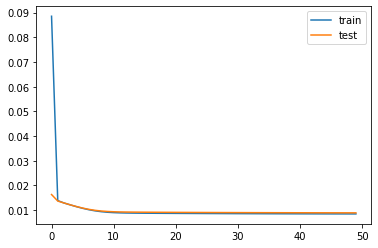

Trying to fit NN with 2 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 9s - loss: 0.0966 - val_loss: 0.0190
Epoch 2/50
4696/4696 - 8s - loss: 0.0163 - val_loss: 0.0150
Epoch 3/50
4696/4696 - 8s - loss: 0.0133 - val_loss: 0.0123
Epoch 4/50
4696/4696 - 8s - loss: 0.0110 - val_loss: 0.0105
Epoch 5/50
4696/4696 - 7s - loss: 0.0098 - val_loss: 0.0097
Epoch 6/50
4696/4696 - 7s - loss: 0.0093 - val_loss: 0.0094
Epoch 7/50
4696/4696 - 8s - loss: 0.0091 - val_loss: 0.0093
Epoch 8/50
4696/4696 - 7s - loss: 0.0090 - val_loss: 0.0092
Epoch 9/50
4696/4696 - 7s - loss: 0.0090 - val_loss: 0.0092
Epoch 10/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0092
Epoch 11/50
4696/4696 - 8s - loss: 0.0089 - val_loss: 0.0091
Epoch 12/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0091
Epoch 13/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0091
Epoch 14/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0091
Epoch 15/50
4696/4696 - 9s - loss: 0.0087 - val_loss: 0.0090
Epoch 16/50
4696/4696 - 8s - loss: 0.

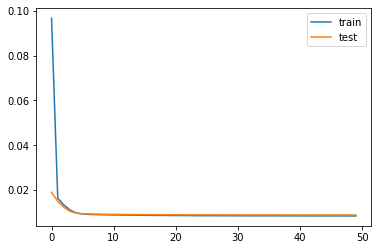

Trying to fit NN with 3 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 8s - loss: 0.0597 - val_loss: 0.0115
Epoch 2/50
4696/4696 - 7s - loss: 0.0104 - val_loss: 0.0104
Epoch 3/50
4696/4696 - 8s - loss: 0.0097 - val_loss: 0.0099
Epoch 4/50
4696/4696 - 8s - loss: 0.0094 - val_loss: 0.0097
Epoch 5/50
4696/4696 - 8s - loss: 0.0092 - val_loss: 0.0096
Epoch 6/50
4696/4696 - 7s - loss: 0.0092 - val_loss: 0.0096
Epoch 7/50
4696/4696 - 7s - loss: 0.0091 - val_loss: 0.0095
Epoch 8/50
4696/4696 - 8s - loss: 0.0091 - val_loss: 0.0095
Epoch 9/50
4696/4696 - 8s - loss: 0.0090 - val_loss: 0.0094
Epoch 10/50
4696/4696 - 7s - loss: 0.0090 - val_loss: 0.0094
Epoch 11/50
4696/4696 - 8s - loss: 0.0090 - val_loss: 0.0094
Epoch 12/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0093
Epoch 13/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0093
Epoch 14/50
4696/4696 - 8s - loss: 0.0089 - val_loss: 0.0093
Epoch 15/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0092
Epoch 16/50
4696/4696 - 8s - loss: 0.

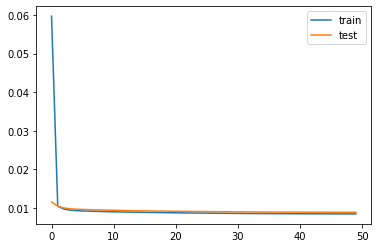

Trying to fit NN with 4 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 10s - loss: 0.0917 - val_loss: 0.0146
Epoch 2/50
4696/4696 - 7s - loss: 0.0129 - val_loss: 0.0124
Epoch 3/50
4696/4696 - 8s - loss: 0.0112 - val_loss: 0.0108
Epoch 4/50
4696/4696 - 7s - loss: 0.0099 - val_loss: 0.0098
Epoch 5/50
4696/4696 - 8s - loss: 0.0092 - val_loss: 0.0094
Epoch 6/50
4696/4696 - 8s - loss: 0.0089 - val_loss: 0.0092
Epoch 7/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 8/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0091
Epoch 9/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0091
Epoch 10/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 11/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 12/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 13/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0090
Epoch 14/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0090
Epoch 15/50
4696/4696 - 8s - loss: 0.0086 - val_loss: 0.0090
Epoch 16/50
4696/4696 - 7s - loss: 0

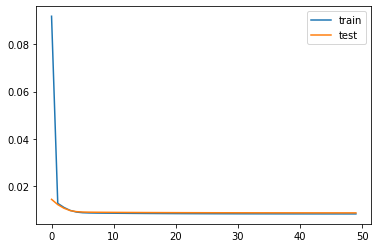

Trying to fit NN with 5 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 9s - loss: 0.0632 - val_loss: 0.0143
Epoch 2/50
4696/4696 - 8s - loss: 0.0121 - val_loss: 0.0113
Epoch 3/50
4696/4696 - 8s - loss: 0.0100 - val_loss: 0.0099
Epoch 4/50
4696/4696 - 7s - loss: 0.0091 - val_loss: 0.0094
Epoch 5/50
4696/4696 - 7s - loss: 0.0089 - val_loss: 0.0093
Epoch 6/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0092
Epoch 7/50
4696/4696 - 7s - loss: 0.0088 - val_loss: 0.0092
Epoch 8/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 9/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 10/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 11/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 12/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 13/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 14/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 15/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 16/50
4696/4696 - 7s - loss: 0.

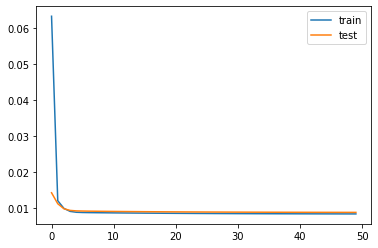

Trying to fit NN with 6 neurons and Learning rate 0.0001
Epoch 1/50
4696/4696 - 9s - loss: 0.0548 - val_loss: 0.0179
Epoch 2/50
4696/4696 - 8s - loss: 0.0150 - val_loss: 0.0135
Epoch 3/50
4696/4696 - 7s - loss: 0.0116 - val_loss: 0.0110
Epoch 4/50
4696/4696 - 8s - loss: 0.0098 - val_loss: 0.0098
Epoch 5/50
4696/4696 - 8s - loss: 0.0091 - val_loss: 0.0093
Epoch 6/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 7/50
4696/4696 - 8s - loss: 0.0088 - val_loss: 0.0092
Epoch 8/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 9/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 10/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 11/50
4696/4696 - 7s - loss: 0.0087 - val_loss: 0.0091
Epoch 12/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 13/50
4696/4696 - 9s - loss: 0.0087 - val_loss: 0.0091
Epoch 14/50
4696/4696 - 8s - loss: 0.0087 - val_loss: 0.0091
Epoch 15/50
4696/4696 - 9s - loss: 0.0087 - val_loss: 0.0091
Epoch 16/50
4696/4696 - 9s - loss: 0.

In [ ]:
# try to fit for the defined neurons and LR   
neurons = np.arange(1,11,1)
learning_rate = [0.0001,0.001,0.01]

for lr in range(len(learning_rate)):
    for n in range(len(neurons)):
        print("Trying to fit NN with "+str(neurons[n])+" neurons and Learning rate "+str(learning_rate[lr]))
        design_and_fit(train_X, train_Y, test_X, test_Y, neurons[n], learning_rate[lr])

## Use the best model to perform a forecast and plot the results

In [ ]:
#pick the best value and recompute the model for prediction
model = design_and_fit(train_X, train_Y, test_X, test_Y, 8, 0.001)

# make a prediction
pred_Y = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X = scaler.inverse_transform(test_X)

# invert scaling for forecast
inv_pred_Y = concatenate((pred_Y, test_X[:, 1:]), axis=1)
inv_pred_Y = scaler.inverse_transform(inv_pred_Y)
inv_pred_Y = inv_pred_Y[:,0]

# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_pred_Y))
print('Test RMSE: %.3f' % rmse)

# plot the prediction and measurments on the test set
LSTM_plot(test_X, inv_y, inv_pred_Y)

## Perform again the same design and fit operation but with all the attitude features as inputs

In [ ]:
# Another NN for LSTM but with all UAV flight parameters as features (7 inputs)
DF = LTE_DATA[['net_param.sinr','gps_param.altitude','net_param.rsrq','gps_param.groundspeed','uav_param.attitude.pitch','uav_param.attitude.yaw','uav_param.attitude.roll']]
DF = DF.sort_values(by="gps_param.altitude")
data = DF.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed)

#Split into test and train
train, test = train_test_split(reframed.values, test_size=0.30, random_state=18)

#Separate inputs and output
train_X, train_Y = train[:, :-1], train[:, -1] 
test_X, test_Y = test[:, :-1], test[:, -1]

#Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

# try to fit for the defined number of neurons and LR
neurons = np.arange(1,11,1)
learning_rate = [0.0001,0.001,0.01]

for lr in range(len(learning_rate)):
    for n in range(len(neurons)):
        print("Trying to fit NN with "+str(neurons[n])+" neurons and Learning rate "+str(learning_rate[lr]))
        design_and_fit(train_X, train_Y, test_X, test_Y, neurons[n], learning_rate[lr])

In [ ]:
#pick the best value and recompute the model for prediction
model = design_and_fit(train_X, train_Y, test_X, test_Y, 7, 0.001)

# make a prediction on the best model
pred_Y = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X = scaler.inverse_transform(test_X)

# invert scaling for forecast
inv_pred_Y = concatenate((pred_Y, test_X[:, 1:]), axis=1)
inv_pred_Y = scaler.inverse_transform(inv_pred_Y)
inv_pred_Y = inv_pred_Y[:,0]

# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_pred_Y))
print('Test RMSE: %.3f' % rmse)

# plot the prediction and measurments on the test set
LSTM_plot(test_X, inv_y, inv_pred_Y)

# LSTM conclusion

Despite the small dataset, LSTM with all the input features related to the UAV attitude (speed, altitude, pitch, roll, yaw, etc) has been able to provide a model stronger than the previous Polynomial Regression, but still weak for a real application of the system. Given also the very computation time of the models, I decided to omit the same procedure for RSRQ parameter.

# LoRaWAN

Perform almost the same operation (data load, clean, and predict) done on LTE data but this time on LoRaWAN data. 

In [ ]:
#Lorawan Data Import and Analysis
data = []
with open('/content/drive/MyDrive/Colab Notebooks/LORAWAN.json') as f:
    for line in f:
        data.append(json.loads(line))

LORA_DATA = pd.json_normalize(data)

#Drop duplicate data where rows have same timestamp
LORA_DATA = LORA_DATA.drop_duplicates(subset=['timestamp'])

#Converto DF into float (only numbers)
LORA_DATA = LORA_DATA.apply(pd.to_numeric, errors='ignore')

#Set LORA condition
LORA_Null = LORA_DATA['satellites']>=5
#LORA_net = LORA_DATA['snr'].notna()
#LORA_net = LORA_DATA['gateways'].notna()

#Select only LORA data
LORA_DATA = LORA_DATA[LORA_Null]

#Convert timestamp into datetime
LORA_DATA["timestamp"] = pd.to_datetime(LORA_DATA["timestamp"])

#Sort by time (needed for time clustering)
LORA_DATA = LORA_DATA.sort_values(by="timestamp")

#Print Dtypes for debug
print(LORA_DATA.dtypes)

LORA_DATA.describe()

## Neural Network

This time, instead of LSTM I decided to use a generic NN with one hidden layer and 30 neurons (I've done some random tests). In the following sections, data are scaled and both test and train tests are defined.

In [ ]:
# Another NN for LSTM but with all UAV flight parameters as features (7 inputs)
DF = LORA_DATA[['rssi','altitude','speed','snr']]
DF = DF.sort_values(by="altitude")
dataset = DF.values

# normalize features
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

#set input and output features
X = dataset[:,0:3]
Y = dataset[:,3].reshape(-1, 1)

#Scaling
X = scalerX.fit_transform(X)
Y = scalerY.fit_transform(Y)

#Split into test and train
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.30, random_state=18)
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

### Define the network and layers

Then compile the model and run it. Finally, plot the loss.

In [ ]:
learning_rate = 0.001

opt = keras.optimizers.Adam(learning_rate)
model = Sequential([
    Dense(30, activation='relu', input_shape=(3,)),
    Dense(30, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(loss='mean_squared_error', optimizer=opt)   
    
hist = model.fit(train_X, train_Y, batch_size=1, epochs=100, validation_data=(test_X, test_Y))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Plot function 

Plot both the measured and predicted SNR for LoRaWAN

In [ ]:
# plot the prediction and measurments on the test set
def NN_plot(test_X, inv_y, inv_pred_Y):   
    # Create figure
    fig_scat = make_subplots()
    fig_lines = make_subplots()

    #Set first data
    fig_scat.add_trace(go.Scatter(x=test_X[:,1], y=inv_y[:,0], mode='markers', name="Measured SNR"))
    fig_scat.add_trace(go.Scatter(x=test_X[:,1], y=inv_pred_Y[:,0], mode='markers', name="Predicted SNR"))
    fig_lines.add_trace(go.Scatter(y=inv_y[:,0], name="Measured SNR"))
    fig_lines.add_trace(go.Scatter(y=inv_pred_Y[:,0], name="Predicted SNR"))
    
    # Set x-axis title
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_lines.update_xaxes(title_text="Samples")
    
    # Set y-axes titles
    fig_scat.update_yaxes(title_text="SNR (dBm)")
    fig_lines.update_yaxes(title_text="SNR (dBm)")
    
    # Set title
    fig_scat.update_layout(title_text="SNR Prediction")
    fig_lines.update_layout(title_text="SNR Prediction vs Measured")
    
    # Show
    fig_scat.show()
    fig_lines.show()

In [ ]:
# make a prediction
pred_Y = model.predict(test_X)

pred_out_Y = scalerY.inverse_transform(pred_Y)
test_out_Y = scalerY.inverse_transform(test_Y)
test_out_X = scalerX.inverse_transform(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_out_Y, pred_out_Y))
print('Test RMSE: %.3f' % rmse)

#Plot prediction vs Measured
NN_plot(test_out_X, test_out_Y, pred_out_Y)

### NN Discussion

Given the small dataset and the nature of the data, the obtained model is poor, with an RMSE of about 0.82. Increasing the number of layers or neurons, increases RMSE. The model seems overfitting a bit the data.

# Plot and Regression Functions

In this section of code, there are some plots and regression functions, as already done with LTE.

In [ ]:
def format_coefs(coefs):
    #Function used to write the legend items as equations
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

def Scatter_plot_speed(DF):
    #Define figure
    fig_speed_scat = go.Figure()
 
    #Clean DF in order to keep only measurement at the "same" altitude, thus removing dependency on altitude
    MAX_Alt = DF['altitude'].max()
    CUT_Alt = MAX_Alt*0.85 #Keep only the real flight data
    DF_Pos = DF['altitude']>CUT_Alt
    DF = DF[DF_Pos]
    fig_speed_scat.add_trace(go.Scatter(x=DF['speed'], y=DF['snr'], mode='markers', name='SNR'))
    fig_speed_scat.add_trace(go.Scatter(x=DF['speed'], y=DF['rssi'], mode='markers', name='RSSI'))
    
    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['speed'].values.reshape(-1,1)
    model.fit(X, DF['snr'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='SNR Lin Reg'))
   
    #Linear Reg for RSRQ
    model = LinearRegression()
    model.fit(X, DF['rssi'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='RSSI Lin Reg'))
    
    #Set plots names
    fig_speed_scat.update_layout(title_text="SNR & RSSI vs UAV Speed")
    
    #Set Axis name
    fig_speed_scat.update_xaxes(title_text="UAV Speed (m/s)")
    fig_speed_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_speed_scat.show()
        
def Scatter_plot_alt(DF):
    #Define figure
    fig_scat = go.Figure()

    #Plot signal quality index by altitude       
    fig_scat.add_trace(go.Scatter(x=DF['altitude'], y=DF['snr'], mode='markers', name='SNR'))
    fig_scat.add_trace(go.Scatter(x=DF['altitude'], y=DF['rssi'], mode='markers', name='RSSI'))

    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['altitude'].values.reshape(-1,1)
    x_range = np.linspace(X.min(), X.max(), 600).reshape(-1, 1)
    for degree in [1, 2, 3]:
        # Get degree and fit
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, DF['snr'])
        y_poly = model.predict(x_range_poly)
        
        # Write as equation
        equation = format_coefs(model.coef_.round(2))
        # Add to plot
        fig_scat.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
       
    #Linear Reg for RSRQ
    model = LinearRegression()
    X = DF['altitude'].values.reshape(-1,1)
    x_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    for degree in [1, 2, 3]:
        # Get degree and fit
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, DF['rssi'])
        y_poly = model.predict(x_range_poly)
        
        # Write as equation
        equation = format_coefs(model.coef_.round(2))
        # Add to plot
        fig_scat.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
    
    #Set plots names
    fig_scat.update_layout(title_text="SNR & RSSI vs UAV Altitude")

    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()
    

def Scatter_map(DF):
    #Create scatter maps
    scat_map = px.scatter_mapbox(DF, lat='latitude', lon='longitude', color='snr', size='longitude', zoom=16,
                        mapbox_style="open-street-map")
    
    # Set plot name
    scat_map.update_layout(title_text="LoRaWAN Coverage Map")
    
    # Show
    scat_map.show()
    
def Flight_plot(DF):              
    # Create figure with secondary y-axis
    fig_lines = make_subplots(specs=[[{"secondary_y": True}]])

    #Set first axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['snr'], name="SINR (dBm)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['altitude'], name="Altitude (m)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['speed'], name="Groundspeed (m/s)"), secondary_y=False)

    #Set second axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['rssi'], name="RSSI (dBm)"), secondary_y=True)
    
    # Set x-axis title
    fig_lines.update_xaxes(title_text="Time")
    
    # Set y-axes titles
    fig_lines.update_yaxes(title_text="Altitude, SNR, Groundspeed", secondary_y=False)
    fig_lines.update_yaxes(title_text="RSSI", secondary_y=True)
    
    # Set title
    fig_lines.update_layout(title_text="LoRaWAN Network and UAV data")
    
    # Show
    fig_lines.show()   

### Time clustering and plots

Perform a time clustering in order to separate different flights. Compared to LTE, the separation time is higher (4 minutes). Then, all the main LoRaWAN network data are plotted using the previous defined functions.

In [ ]:
#Convert timestamp of dataframe to python datetime
LORA_DATA.timestamp = LORA_DATA.timestamp.dt.to_pydatetime()

#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=4)
final = list()
tmp = list()

#First row
tmp.append(LORA_DATA.iloc[0,:])

#First datetime
previous = LORA_DATA.iloc[0,0]

#Scan dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LORA_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 50 rows
lora_flights = []
for i in range(len(final)):
    #print(len(final[i]))
    if len(final[i])>50:
        lora_flights.append(final[i])
   
#Remove incomplete flights where there are missing data by check initial and final altitude with a 10 meter error margin due to air pressure change
lora_complete_flights = []
for i in range(len(lora_flights)):
    data = DataFrame (lora_flights[i])
    rth = abs(data.iloc[0,5] - data.iloc[-1,5])
    if rth<10:
        lora_complete_flights.append(data)
    
#Print complete flight
print("Found", len(lora_complete_flights), "complete flights:")
for i in range(len(lora_complete_flights)):
    print("Flight N°", i+1, "has ", len(lora_complete_flights[i]), " rows of data")
    
#Print complete flight data plots
for f in range(len(lora_complete_flights)):
    DF = DataFrame (lora_complete_flights[f])

    #Call Plot functions
    Flight_plot(DF)
    Scatter_map(DF)
    Scatter_plot_alt(DF)
    Scatter_plot_speed(DF)  


### Plot the entire dataset

In [ ]:
Scatter_map(LORA_DATA)
Scatter_plot_alt(LORA_DATA)
Scatter_plot_speed(LORA_DATA)  

# Polynomial Regression

Define two polynomial regression function, one for SNR and one for RSSI. The functions are almost the same as already seen for LTE.

In [ ]:
#Performing some real Poly Reg to find a suitable model for SNR prediction at different height, since speed does not affect SNR index
def lora_polynomial_regression_model_snr(degree):
    print("Creates a polynomial regression model for "+str(degree)+" degree")
    poly = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_poly = poly.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    model = LinearRegression()
    model.fit(X_poly, Y_snr_train)

    # predicting on training data-set
    y_train_predicted = model.predict(X_poly)

    # predicting on test data-set
    y_test_predict = model.predict(poly.transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_snr_train, y_train_predicted))
    r2_train = r2_score(Y_snr_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_snr_test, y_test_predict))
    r2_test = r2_score(Y_snr_test, y_test_predict)
    
    #Define figure
    fig_scat = go.Figure()
    
    #Plot Train & Test Data
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=Y_snr_train[:,0], mode='markers', name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=Y_snr_test[:,0], mode='markers', name='Test'))

    #Add Linear Regression
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=y_train_predicted[:,0], name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=y_test_predict[:,0], name='Test'))
    
    #Set plots names
    fig_scat.update_layout(title_text="SNR vs UAV Alt")
    
    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()

    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")
    
def lora_polynomial_regression_model_rssi(degree):
    print("Creates a polynomial regression model for "+str(degree)+" degree")
    poly = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_poly = poly.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    model = LinearRegression()
    model.fit(X_poly, Y_rssi_train)

    # predicting on training data-set
    y_train_predicted = model.predict(X_poly)

    # predicting on test data-set
    y_test_predict = model.predict(poly.transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_rssi_train, y_train_predicted))
    r2_train = r2_score(Y_rssi_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_rssi_test, y_test_predict))
    r2_test = r2_score(Y_rssi_test, y_test_predict)
    
    #Define figure
    fig_scat = go.Figure()
    
    #Plot Train & Test Data
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=Y_rssi_train[:,0], mode='markers', name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=Y_rssi_test[:,0], mode='markers', name='Test'))

    #Add Linear Regression
    fig_scat.add_trace(go.Scatter(x=X_train[:,0], y=y_train_predicted[:,0], name='Train'))
    fig_scat.add_trace(go.Scatter(x=X_test[:,0], y=y_test_predict[:,0], name='Test'))
    
    #Set plots names
    fig_scat.update_layout(title_text="RSSI vs UAV Alt")
    
    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()

    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")

### Create train and tests sets for both SNR and RSSI Poly

Then call the two functions defined above.

In [ ]:
#From DF to NP array
array = LORA_DATA.values

#Get only usefull colums
X = array[:,5]
Y_rssi = array[:,1]
Y_snr = array[:,2]

#Split into test and train
X_train, X_test, Y_rssi_train, Y_rssi_test, Y_snr_train, Y_snr_test = train_test_split(X, Y_rssi, Y_snr, test_size=0.20, random_state=1)

#Reshape to 2D
X_train = X_train.reshape(-1, 1)
Y_rssi_train = Y_rssi_train.reshape(-1, 1)
Y_snr_train = Y_snr_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_rssi_test = Y_rssi_test.reshape(-1, 1)
Y_snr_test = Y_snr_test.reshape(-1, 1)

#Order by X
Y_rssi_train = Y_rssi_train[X_train[:,0].argsort()]
Y_snr_train = Y_snr_train[X_train[:,0].argsort()]
X_train = X_train[X_train[:,0].argsort()]
Y_rssi_test = Y_rssi_test[X_test[:,0].argsort()]
Y_snr_test = Y_snr_test[X_test[:,0].argsort()]
X_test = X_test[X_test[:,0].argsort()]
    
# Evaluate Logisti Regression Perf
for degree in [1, 2, 3, 4, 5]:
    lora_polynomial_regression_model_snr(degree)
    lora_polynomial_regression_model_rssi(degree)

# Polynomial Regression Discussion

### SNR

All the models with different degrees of freedom have low R2 scores. The best one is the Polynomial Regression with 3 DoF, which has a R2 score of about 0.49 and an RMSE of 3. The model with 4 and 5 DoF heavily overfit the dataset.

### RSSI

Both 2 and 3 Dof have similar performance and R2 scores, while the 4 and 5 DoF model clearly overfit the data set.

## Conclusion

The low number of input data makes the Polynomial Regression not suitable for a strong model, however 3 DoF models are already *on-track* with the real behaviour of the network parameter.

# Wi-Fi (To be completed)

Unfortunately Wi-Fi data are completely different and actually can not be used to make a prediction model, since they have been taken in a wrong way (just a passive scan of nearby Wi-Fi networks), that's why I decided to omit it for now.